In [1]:
%matplotlib widget
from datetime import datetime
from zoneinfo import ZoneInfo
from pathlib import Path
from neuroconv import ConverterPipe
from neuroconv.datainterfaces import DeepLabCutInterface, VideoInterface
import pandas as pd
import numpy as np
import pprint

from matplotlib import pyplot as plt

In [2]:
def _find_in_folder(folder, pattern):
    return next(folder.glob(pattern))

## Videos and DLC

In [3]:
def _copy_and_update_config_file(config_file_path, video_file_path, dest_dir=None, overwrite=False):
    # Copy config file to data folder:
    config_file_path = Path(config_file_path)
    video_file_path = Path(video_file_path)
    if dest_dir is None:
        dest_dir = video_file_path.parent
    else:
        dest_dir = Path(dest_dir)

    config_file_path_copy = dest_dir / config_file_path.name

    if not overwrite and config_file_path_copy.exists():
        print(f"Config file already exists in {config_file_path_copy}.")
        return config_file_path_copy

    config_file_text = config_file_path.read_text()
    # find crop by looking for content in between crop: and \n:
    crop = config_file_text.split("crop: ")[1].split("\n")[0]
    config_file_text = config_file_text.replace("\nvideo_sets:\n  ", 
                            f"\nvideo_sets:\n  {video_file_path}:\n    crop: {crop}\n  ")
    config_file_path_copy.write_text(config_file_text)

    return config_file_path_copy

mid = "M21"
day = "20240421"
ses = "165242"
data_folder = Path(f"/Users/vigji/Desktop/test_mpa_dir/{mid}/{day}/{ses}")
video_data = {"eye": {"name": "EyeCamera",
                      "description": "Magnified view of the animal's pupil.", 
                      "dlc_model_path": "/Volumes/SystemsNeuroBiology/SNeuroBiology_shared/DLC_models/eye-pupil-Luigi Petrucco-2023-12-16/config.yaml"},
              "top": {"name": "TopCamera",
                      "description": "Top view of the animal's head and body in the setup.", 
                      "dlc_model_path": "/Volumes/SystemsNeuroBiology/SNeuroBiology_shared/DLC_models/top-cam-Luigi Petrucco-2023-12-16/config.yaml"},
                      }

path_to_save_nwbfile = data_folder / f"{mid}_{day}_{ses}.nwb" 

dlc_interfaces = []
video_interfaces = []
video_dicts = []
for i_cam, camera in  enumerate(["eye", "top"]):
    dlc_file_path = _find_in_folder(data_folder, f"*{camera.title()}*.h5")
    video_file_path = _find_in_folder(data_folder, f"*{dlc_file_path.stem.split('DLC')[0]}*.avi")
    timestamps_file_path = _find_in_folder(data_folder, f"*{dlc_file_path.stem.split('DLC')[0][-10:]}*.csv")
    config_file_path = video_data[camera]["dlc_model_path"]
    # update config file with video path:
    config_file_path = _copy_and_update_config_file(config_file_path, video_file_path)

    # load framerate csv:
    framerate_df = pd.read_csv(timestamps_file_path)
    # convert to datetime the Timestamp column strings to seconds from first timestamp:
    timestamps = pd.to_datetime(framerate_df["Timestamp"])
    timestamps = (timestamps - timestamps[0]).dt.total_seconds().values

    dlc_interface = DeepLabCutInterface(file_path=dlc_file_path, config_file_path=config_file_path, subject_name=mid, verbose=False)
    dlc_interface.set_aligned_timestamps(timestamps)

    dlc_interfaces.append(dlc_interface)

    video_interface = VideoInterface(file_paths=[video_file_path], 
                                     # timestamps=[timestamps],
                                     verbose=False, 
                                     metadata_key_name=video_data[camera]["name"])
    print(len(timestamps))
    video_interface.set_aligned_timestamps([timestamps])
    video_interfaces.append(video_interface)
    video_dict = {"file_path": video_file_path, 
                  "description": video_data[camera]["description"], 
                  "name": video_data[camera]["name"],
                  "interface_num": f"00{i_cam+1}",
                  "timestamps": timestamps,}
    video_dicts.append(video_dict)


Config file already exists in /Users/vigji/Desktop/test_mpa_dir/M21/20240421/165242/config.yaml.
268646
Config file already exists in /Users/vigji/Desktop/test_mpa_dir/M21/20240421/165242/config.yaml.
268646


video_interface = VideoInterface(file_paths=[v["file_path"] for v in video_dicts], verbose=False)
video_interface.set_aligned_timestamps([v["timestamps"] for v in video_dicts])
video_metadata = video_interface.get_metadata()
for video_dict, cam_metadata in zip(video_dicts, video_metadata["Behavior"]["Videos"]):
    cam_metadata.update({k: video_dict[k] for k in ["name", "description"]})
video_metadata.to_dict()

In [22]:
conv_pipe = ConverterPipe([*video_interfaces, *dlc_interfaces, ], 
                          verbose=True)  
# remove file if it exists:
if path_to_save_nwbfile.exists():
    path_to_save_nwbfile.unlink()


metadata = conv_pipe.get_metadata()
# For data provenance we add the time zone information to the conversion
session_start_time = datetime(2020, 1, 1, 12, 30, 0, tzinfo=ZoneInfo("US/Pacific"))
metadata["NWBFile"].update(session_start_time=session_start_time)
# pprint.pprint(metadata.to_dict())
# Choose a path for saving the nwb file and run the conversion
conversion_options = {f"DeepLabCutInterface{v['interface_num']}": dict(container_name=v["name"]) for v in video_dicts}
conv_pipe.run_conversion(nwbfile_path=path_to_save_nwbfile, metadata=metadata, conversion_options=conversion_options)

Metadata is valid!
conversion_options is valid!


/Users/vigji/code/DLC2NWB/dlc2nwb/utils.py:101: UserWarning: Replacing cv2 timestamps returned as 0: 0.003350%
  warnings.warn( # warns user of percent of 0 frames
/Users/vigji/code/neuroconv/src/neuroconv/datainterfaces/behavior/deeplabcut/deeplabcutdatainterface.py:49: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_animal = df.groupby(level="individuals", axis=1).get_group(individual_name)
/Users/vigji/code/DLC2NWB/dlc2nwb/utils.py:204: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for kpt, xyp in df_animal.groupby(level="bodyparts", axis=1, sort=False):
/Users/vigji/code/DLC2NWB/dlc2nwb/utils.py:181: UserWarning: The video file corresponding to /Users/vigji/Desktop/test_mpa_dir/M21/20240421/165242/TopCamera__video_2024-04-21T16_52_14DLC_resnet50_top-camDec16shuffle1_7000.h5 could not be found...
  warnings.warn(f"The video file corresponding to {h5file} c

NWB file saved at /Users/vigji/Desktop/test_mpa_dir/M21/20240421/165242/M21_20240421_165242.nwb!


In [50]:
video_file_path = video_file_path

## Timeseries

In [27]:
from neuroconv.datainterfaces import CsvTimeIntervalsInterface

file_path = _find_in_folder(data_folder, "*laser-log*.csv")

# Change the file_path to the location of the file in your system
interface = CsvTimeIntervalsInterface(file_path=file_path, verbose=False)

# Extract what metadata we can from the source files
metadata = interface.get_metadata()
# Add the time zone information to the conversion
session_start_time = datetime(2020, 1, 1, 12, 30, 0, tzinfo=ZoneInfo("US/Pacific"))
metadata["NWBFile"] = dict(session_start_time=session_start_time)

nwbfile_path = f"{path_to_save_nwbfile}" # This should be something like: "./saved_file.nwb"
nwbfile = interface.run_conversion(nwbfile_path=nwbfile_path, metadata=metadata)

/Users/vigji/miniconda3/envs/lab-env/lib/python3.10/site-packages/pynwb/base.py:203: UserWarning: PoseEstimationSeries 'M21_cube-l': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/Users/vigji/miniconda3/envs/lab-env/lib/python3.10/site-packages/pynwb/base.py:203: UserWarning: PoseEstimationSeries 'M21_cube-mid': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
/Users/vigji/miniconda3/envs/lab-env/lib/python3.10/site-packages/pynwb/base.py:203: UserWarning: PoseEstimationSeries 'M21_cube-r': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match l

ValueError: df must contain a column named 'start_time'. Existing columns: ['Value', 'Timestamp']

## Get timestamps from digital logs

In [4]:
import spikeinterface.full as si
from labnpx.digital_signal import DigitalSignal
from labnpx.barcode_signal import BarcodeSignal

dwnsamp = 10
f = Path("/Users/vigji/Desktop/test_mpa_dir/M21/2024-04-21_16-51-50")
digital_traces_interface = si.read_openephys(str(f), stream_name="Record Node 103#NI-DAQmx-102.USB-6212 (BNC)")

fs = int(digital_traces_interface.sampling_frequency)
target_fs = int(fs / dwnsamp)

traces_array = np.array(digital_traces_interface.get_traces()[::dwnsamp, :])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


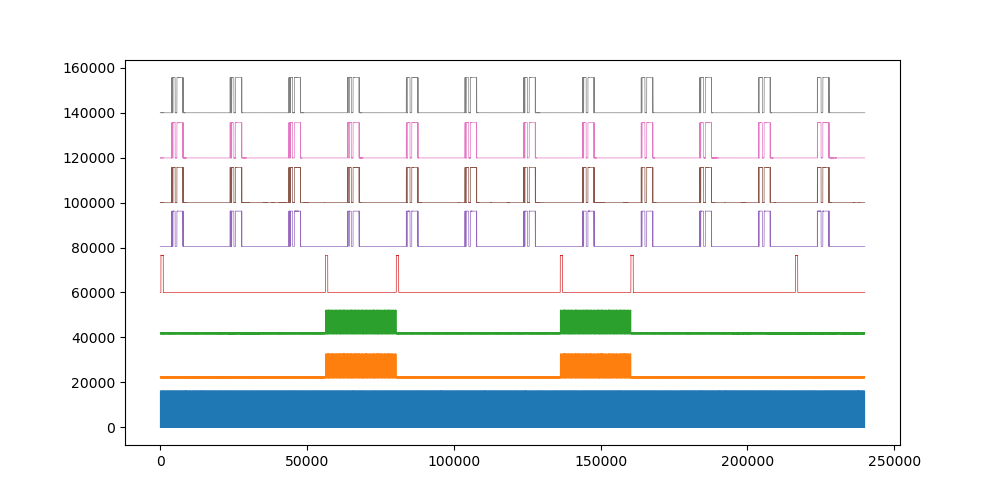

In [8]:
plot = False
if plot:
    t_lims = (1000, 1060)
    t_slice = slice(target_fs*t_lims[0], target_fs*t_lims[1])
    plt.figure(figsize=(10, 5))
    for idx in range(8):
        plt.plot(traces_array[t_slice, idx]+20000*idx, lw=0.5)

In [81]:
#channels map
channels_map = {0: 'frames', 1: 'laser', 2: '-', 3: 'motor', 4: 'barcode', 5: '-', 6: '-', 7: '-'}
thr = 10000  # threshold for digital signals
assumed_trial_len_s = 6.2
min_trial_distance_s = 1
tolerance = 0.3
# Create a DigitalSignal objects dictionary for valid channels:
digital_signals = {}
for idx in range(8):
    if channels_map[idx] != '-':
        digital_signals[channels_map[idx]] = DigitalSignal(traces_array[:, idx] > thr, fs=target_fs)

In [82]:
# get camera frames triggers, and raise relative warnings if needed
camera_timestamps = digital_signals["frames"].onsets_times
assert camera_timestamps[0] > 1, "Camera frames trigger starts too early, could have missed something"
# assert camera_timestamps[-1] < (digital_signals["frames"].duration - 1), "Camera frames trigger ends too late, could have missed something"

In [83]:
def _validate_timestamps(trials_df, trials_digital_onsets, tolerance=0.1):
    """Function to validate trial timestamps from csv log and digital signals.

    Parameters
    ----------
    trials_df : pd.DataFrame
        Dataframe with trial timestamps, with a "Timestamp" column.
    trials_digital_onsets : np.ndarray
        Array with trial onsets from digital signals.
    tolerance : float, optional
        Max tolerated time mismatch, by default 0.1
    """
    assert len(trials_df) == len(trials_digital_onsets), "Number of trials in laser log does not match number of trials in digital signals"

    # convert timestamp from 2024-04-21T16:58:03.6325504+02:00 format:
    trial_onsets_df = pd.to_datetime(trials_df["Timestamp"])
    trial_intervals_df = trial_onsets_df.diff().dt.total_seconds().values[1:]
    # compare log and digital signal derived trial intervals:
    assert np.allclose(trial_intervals_df, np.diff(trials_digital_onsets), atol=tolerance), \
        "Trial intervals from log and digital signals do not match"

# get laser triggers
laser_onsets = digital_signals["laser"].onsets_times
laser_offsets = digital_signals["laser"].offsets_times

# trial onsets/offsets are the onsets which distance to the previous/next onset/offset 
# is greater than 0.5 s, plus the first onset.
laser_trial_onsets = np.concatenate([[laser_onsets[0]], laser_onsets[1:][np.diff(laser_onsets) > min_trial_distance_s]])
laset_trial_offsets = np.concatenate([laser_offsets[:-1][np.diff(laser_onsets) > min_trial_distance_s], [laser_offsets[-1]]])

# read laser log and cross check number of trials:
laser_log_file = _find_in_folder(data_folder, "*laser-log*.csv")
laser_log_df = pd.read_csv(laser_log_file)

_validate_timestamps(laser_log_df, laser_trial_onsets, tolerance=tolerance)


In [84]:
# get motor triggers
motor_onsets = digital_signals["motor"].onsets_times
motor_offsets = digital_signals["motor"].offsets_times

# motor trial start times are one onset every 2 offsets; motor trial end times are one offset every 2 onsets.
# First movement is the initial reset and is not a trial.
motor_trial_onsets = motor_onsets[1::2]
motor_trial_offsets = motor_offsets[2::2]
# check that all trials are around 6.2 seconds long:
assert np.allclose(motor_trial_offsets - motor_trial_onsets, assumed_trial_len_s, atol=tolerance), "Some motor trials are not around 6.2 seconds long"

# double check with motor log:
motor_log_file = _find_in_folder(data_folder, "*motor-log*.csv")
motor_log_df = pd.read_csv(motor_log_file)
# trials are one every two entries, skipping the first one:
motor_log_df = motor_log_df.loc[1::2, :]
assert len(motor_trial_onsets) == len(motor_log_df), "Number of trials in motor log does not match number of trials in digital signals"

_validate_timestamps(motor_log_df, motor_trial_onsets, tolerance=tolerance)


## Align timestamps to ephys log

PosixPath('/Users/vigji/Desktop/test_mpa_dir/M21/20240421/165242')

In [167]:
def _array_from_oephys_events(npx1_traces_events, fs, pad_s=5):
    """Create a boolean array from a list of events.

    Parameters
    ----------
    events : list
        List of tuples with event onset and duration.
    fs : int
        Sampling frequency.
    length : int
        Length of the array.

    Returns
    -------
    np.ndarray
        Boolean array with events.
    """
    # create
    barcodes_times = np.array([(evt[0], evt[1]) for evt in list(npx1_traces_events.get_events('Neuropixels PXI Sync'))])
    n_pts = int((barcodes_times[-1, 0] + pad_s)*fs)
    barcodes_array = np.zeros(n_pts, dtype=bool)

    for onset, duration in barcodes_times:
        onset_idx = int(onset*barcodes_fs)
        offset_idx = int((onset + duration)*barcodes_fs)
        barcodes_array[onset_idx:offset_idx] = True

    return barcodes_array


f = next(data_folder.parent.parent.glob("*-*"))  # find ephys folder

# Read traces and synch events:
npx1_traces_events = si.read_openephys_event(str(f))
digital_traces_interface = si.read_openephys(str(f), stream_name="Record Node 103#Neuropix-PXI-100.ProbeB-AP")
barcodes_fs = digital_traces_interface.get_sampling_frequency()
barcodes_array = _array_from_oephys_events(npx1_traces_events, barcodes_fs)

barcode_signal_npx = BarcodeSignal(barcodes_array, fs=barcodes_fs)
barcode_signal_ni = BarcodeSignal(digital_signals["barcode"].array, fs=digital_signals["barcode"].fs)


In [166]:
barcode_signal_ni.map_times_to(barcode_signal_npx, motor_trial_onsets)

array([ 746.93063006,  766.9159442 ,  786.93750846,  806.95582271,
        826.97488696,  846.99845122,  867.00601543,  887.01732966,
        907.03189389,  927.04345811,  947.06452237,  967.07083658,
        987.0804008 , 1007.09921504, 1027.10752926, 1047.11309346,
       1067.12990771, 1087.15022196, 1107.17953624, 1127.17410041,
       1147.17766461, 1167.18622883, 1187.19179303, 1207.20035725,
       1227.21592148, 1247.24223576, 1267.24754996, 1287.2628642 ,
       1307.27367842, 1327.28199264, 1347.29230686, 1367.30262108,
       1387.32393533, 1407.32474952, 1427.34731378, 1447.36237802,
       1467.38119227, 1487.39075649, 1507.39432069, 1527.4038849 ,
       1547.41869914, 1567.43001336, 1587.43682757, 1607.45514182,
       1627.46045602, 1647.46602023, 1667.47308444, 1687.48464867,
       1707.51346295, 1727.51902715, 1747.53234138, 1767.54865562,
       1787.55096982, 1807.56128404, 1827.57709828, 1847.5879125 ,
       1867.59797672, 1887.61379096, 1907.63935523, 1927.64366